# QC and Normalisation Workflow

This notebook demonstrates a comprehensive quality control and normalisation workflow for LC/MS-MS phosphoproteomics experiment data. The steps include removing low-quality samples and phosphosites, and between-sample normalisation of peak areas via median scaling.

## Workflow Overview:
1. **Quality Control - Exclude Low-Quality Samples:** Remove samples that do not meet predefined quality standards.
2. **Quality Control - Exclude Low-Quality Phosphosites:** Remove phosphosites with a high proportion of NA values.
3. **Normalisation:** Normalise peak areas between samples using median scaling to make samples comparable.

Let's start by importing necessary libraries and loading our dataset.

In [1]:
# Import necessary libraries
import pandas as pd
import os
import logging

# Import functions from the data_wrangling module
import src.qc_and_normalisation as qcn

# Configure logging
logging.basicConfig(level=logging.INFO)

# Set working directory
os.chdir('../')

## Loading Phosphoproteomics Data

We start by loading our dataset containing Area Under the Peak (AUP) data from LC-MS/MS phosphoproteomics experiments. Rows represent phosphosites (or features), and columns represent samples.

In [2]:
# Load the dataset
log2aup = pd.read_csv('workspace/preprocessed_data.tsv', sep='\t', index_col=0)

# Display the first few rows of the dataset
log2aup.head()

,b1790p087_MCF7_AC220_1,b1790p087_MCF7_AC220_2,b1790p087_MCF7_AC220_3,b1790p087_MCF7_AC220_4,b1790p086_MCF7_Amuvatinib_1,b1790p086_MCF7_Amuvatinib_2,b1790p086_MCF7_Amuvatinib_3,b1790p086_MCF7_Amuvatinib_4,b1790p091_MCF7_AT13148_1,b1790p091_MCF7_AT13148_2,...,b1790p085_MCF7_U73122_3,b1790p085_MCF7_U73122_4,b1790p085_MCF7_Ulixertinib_1,b1790p085_MCF7_Ulixertinib_2,b1790p085_MCF7_Ulixertinib_3,b1790p085_MCF7_Ulixertinib_4,b1790p091_MCF7_Vemurafenib_1,b1790p091_MCF7_Vemurafenib_2,b1790p091_MCF7_Vemurafenib_3,b1790p091_MCF7_Vemurafenib_4
AAAS(S495),32.896346,32.739687,32.303542,32.262632,31.360080,31.353708,31.260036,31.327017,32.427601,32.122839,...,31.892032,31.723375,31.421182,31.767499,31.576630,32.058853,32.304805,32.031872,32.068424,32.020643
AAGAB(S310),28.801965,28.723032,29.125469,29.284707,27.913905,27.922498,26.890910,27.763465,25.475470,25.570484,...,NaN,NaN,28.943441,29.007726,25.700312,NaN,NaN,24.831618,NaN,25.668625
AAGAB(S311),29.603953,29.506551,29.684819,30.093038,27.913905,27.922498,26.890910,27.763465,26.120034,26.071147,...,NaN,NaN,28.943441,29.007726,25.700312,NaN,25.403631,26.068589,NaN,26.269990
AAK1(S14),29.575021,30.067172,27.464128,27.371509,27.121194,27.607830,27.373558,27.460912,30.691728,30.196056,...,30.123157,30.085080,29.916661,28.433314,29.886630,30.375487,30.046014,30.150221,29.781589,30.150723
AAK1(S21),30.223344,29.938713,30.019080,29.695886,28.170273,29.002933,28.836958,28.611766,28.686444,28.577736,...,29.077897,29.551594,29.163582,28.199105,28.920988,29.207683,28.187792,28.440273,28.614614,28.551165


In [3]:
# Load the metadata
metadata = pd.read_csv('resources/raw_data/metadata.tsv', sep='\t')

# Display the first few rows of the metadata
metadata.head()

,name,perturbagen,cell_line,batch,rep,sampleID,status
0,b1790p087_MCF7_AC220_PP1_r1,AC220,MCF7,b1790p087,1,b1790p087_MCF7_AC220_1,perturbed
1,b1790p087_MCF7_AC220_PP1_r2,AC220,MCF7,b1790p087,2,b1790p087_MCF7_AC220_2,perturbed
2,b1790p087_MCF7_AC220_PP2_r1,AC220,MCF7,b1790p087,3,b1790p087_MCF7_AC220_3,perturbed
3,b1790p087_MCF7_AC220_PP2_r2,AC220,MCF7,b1790p087,4,b1790p087_MCF7_AC220_4,perturbed
4,b1790p086_MCF7_MP-470_PP1_r1,Amuvatinib,MCF7,b1790p086,1,b1790p086_MCF7_Amuvatinib_1,perturbed


# 1. Quality Control: Excluding Low-Quality Samples

Quality control is essential in phosphoproteomics data analysis to ensure the reliability of downstream analysis. This step evaluates each sample by comparing the number of quantified phosphosites against the total number of phosphosites across all samples. Samples falling below a specified quantification threshold are considered of low quality and are subsequently removed. This process helps to mitigate the impact of poorly quantified samples on the analysis.

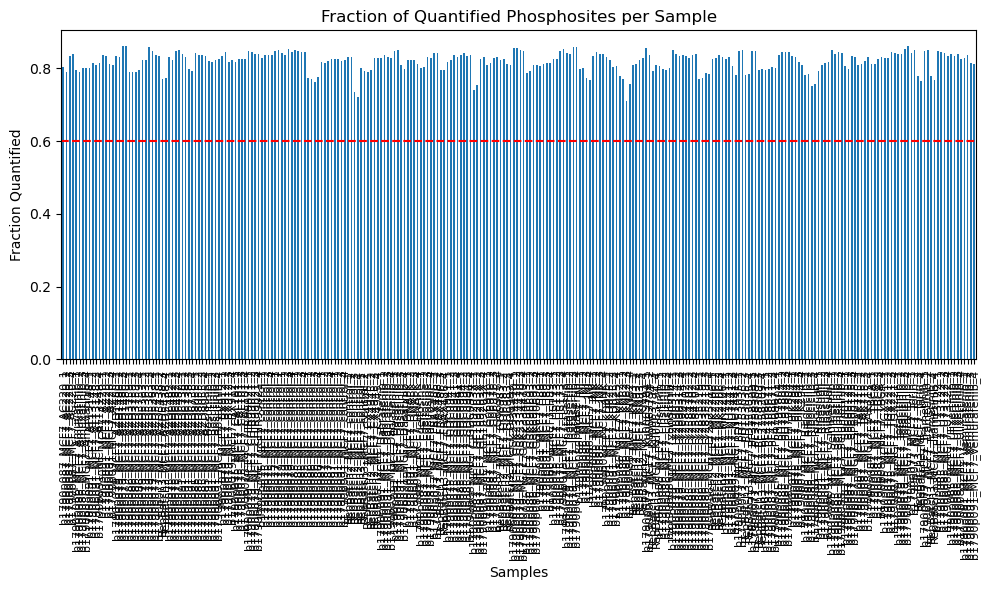

INFO:root:Removed 0 low-quality samples. Retained 276 samples.


In [4]:
# Filter out low-quality samples based on their fraction of quantified phosphosites.
# save_path=None: Optional. If provided, the function will save a plot visualizing the fraction of quantified phosphosites per sample.
log2aup_s, metadata_s = qcn.filter_lq_samples(log2aup, metadata, p_quant=0.6, save_path=None)

# 2. Quality Control: Excluding Low-Quality Phosphosites

During phosphoproteomics analysis, it's not uncommon to encounter phosphosites quantified in a limited number of samples, resulting in a dataset with a significant number of NA values. These instances can arise due to the low abundance of certain phosphosites or challenges in their detection via LC-MS/MS.

In the following step we determine whether to retain or exclude a phosphosite from further analysis by examining:

- The number of measurements available per condition (**n_rep**): A phosphosite quantified in one or two conditions (**n_cond**) may still offer valuable insights for those specific conditions, despite being NA in others. In such cases, at least two measurements are essential to enable fold change and confidence score calculations.

- The fraction of NA values for each phosphosite across all samples (**p_nas**): Some phosphosites, while challenging to detect (thus, rarely achieving more than one measurement per condition), might be present in a significant fraction of the dataset (e.g., 50% of samples). These are also retained and addressed through a workaround for missing fold change estimation, which will be detailed in '04-mh-estimate-missing-fcs.ipynb'.

In [5]:
# Filtering out low-quality phosphosites from phosphoproteomics data
# The criteria for filtering are based on the availability of measurements across samples and conditions.
log2aup_sp, removed_phosphosites = qcn.filter_lq_phosphosites(
    log2aup_s,
    metadata_s,
    condition_col='perturbagen',  # The column in metadata indicating the experimental condition
    n_rep=2,  # Minimum number of replicates per condition required
    n_cond=1,  # Minimum number of conditions a phosphosite must be quantified in
    p_nas=0.5  # Maximum allowed proportion of NA values across all samples for a phosphosite
)

# Calculate the number of samples where a specified phosphosite is NA
print("Total number of samples: ", len(log2aup_sp.columns))
print(removed_phosphosites.isna().sum(axis=1).sort_values())
# Display the first few rows of the removed phosphosites
removed_phosphosites.head()

INFO:root:Removed 128 low-quality phosphosites. Retained 13564 phosphosites out of 13692 total phosphosites.


Total number of samples:  276
TRIM38(Y280)    258
INPP5D(Y865)    258
PPP1R1A(T38)    262
TBC1D4(S106)    265
ZBTB2(T430)     267
               ... 
HMGA2(S102)     276
HMGA2(S101)     276
SALL3(S39)      276
MAP1B(S1242)    276
ZNF532(S434)    276
Length: 128, dtype: int64


,b1790p087_MCF7_AC220_1,b1790p087_MCF7_AC220_2,b1790p087_MCF7_AC220_3,b1790p087_MCF7_AC220_4,b1790p086_MCF7_Amuvatinib_1,b1790p086_MCF7_Amuvatinib_2,b1790p086_MCF7_Amuvatinib_3,b1790p086_MCF7_Amuvatinib_4,b1790p091_MCF7_AT13148_1,b1790p091_MCF7_AT13148_2,...,b1790p085_MCF7_U73122_3,b1790p085_MCF7_U73122_4,b1790p085_MCF7_Ulixertinib_1,b1790p085_MCF7_Ulixertinib_2,b1790p085_MCF7_Ulixertinib_3,b1790p085_MCF7_Ulixertinib_4,b1790p091_MCF7_Vemurafenib_1,b1790p091_MCF7_Vemurafenib_2,b1790p091_MCF7_Vemurafenib_3,b1790p091_MCF7_Vemurafenib_4
ABLIM1(S353),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ADD2(S592),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AKAP12(S505),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AKAP2(T781),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ANKRD33B(S405),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 3. Normalisation of Phosphosite Peak Areas

Normalisation is a pivotal step in the data preprocessing pipeline. It adjusts the phosphosite peak area values across samples to a common scale, reducing technical variation that is not attributable to biological differences. We apply median scaling normalisation to ensure that all samples have the same median intensity value. This method is particularly effective in mitigating the impact of systematic biases and allows for more accurate comparisons across samples.

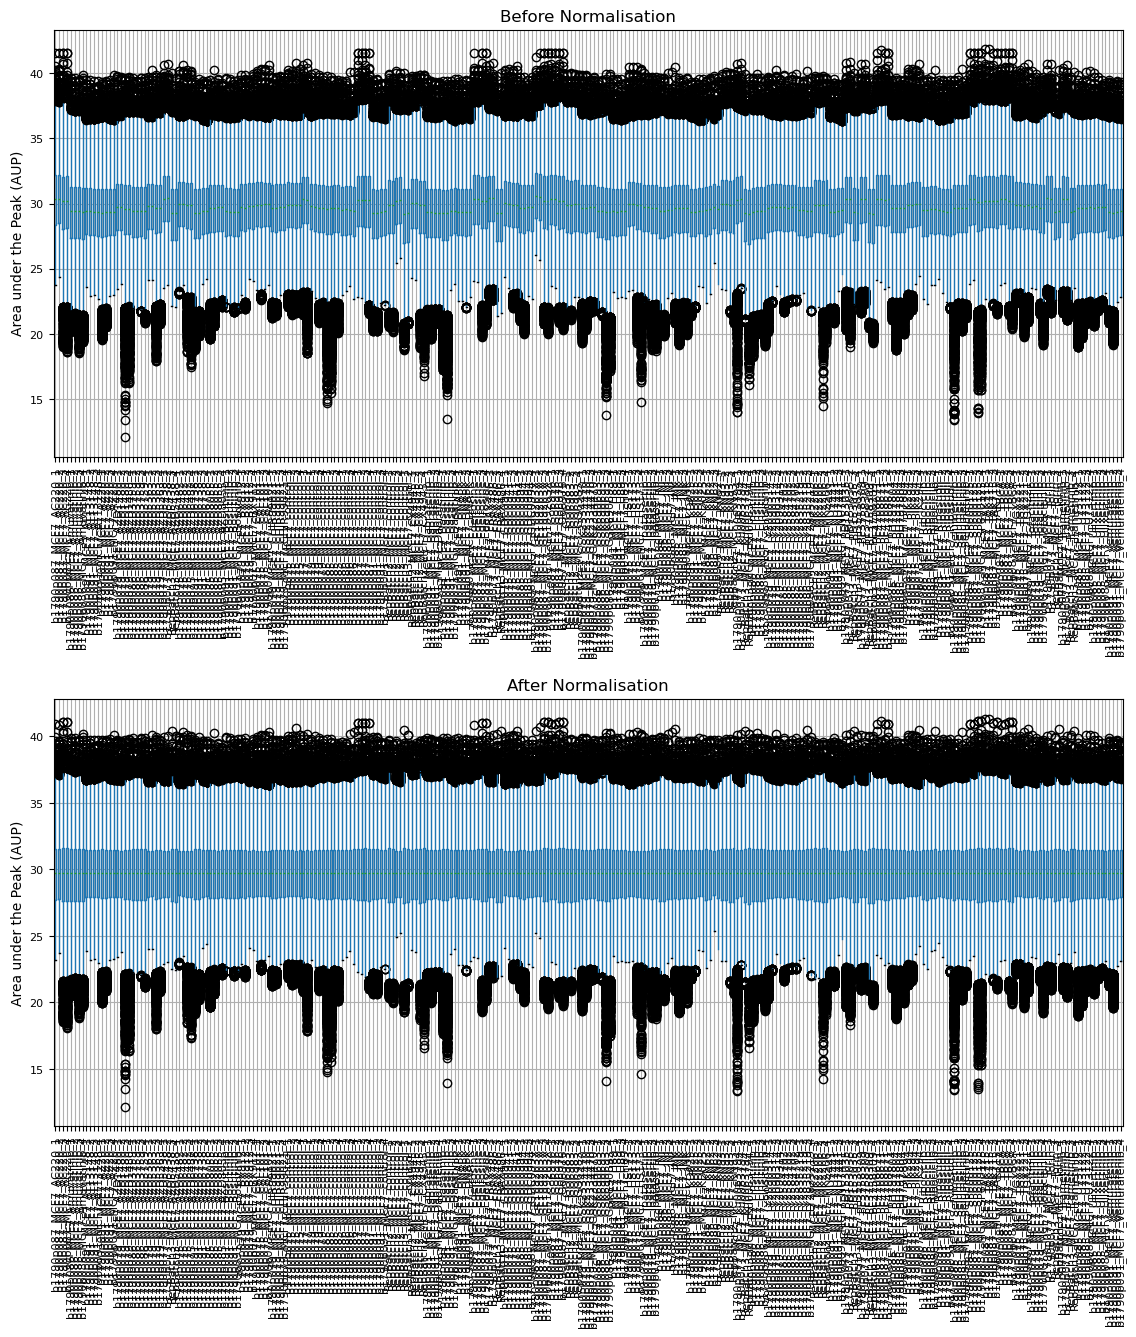

,b1790p087_MCF7_AC220_1,b1790p087_MCF7_AC220_2,b1790p087_MCF7_AC220_3,b1790p087_MCF7_AC220_4,b1790p086_MCF7_Amuvatinib_1,b1790p086_MCF7_Amuvatinib_2,b1790p086_MCF7_Amuvatinib_3,b1790p086_MCF7_Amuvatinib_4,b1790p091_MCF7_AT13148_1,b1790p091_MCF7_AT13148_2,...,b1790p085_MCF7_U73122_3,b1790p085_MCF7_U73122_4,b1790p085_MCF7_Ulixertinib_1,b1790p085_MCF7_Ulixertinib_2,b1790p085_MCF7_Ulixertinib_3,b1790p085_MCF7_Ulixertinib_4,b1790p091_MCF7_Vemurafenib_1,b1790p091_MCF7_Vemurafenib_2,b1790p091_MCF7_Vemurafenib_3,b1790p091_MCF7_Vemurafenib_4
AAAS(S495),32.275187,32.045282,31.826052,31.750970,31.647925,31.617221,31.560099,31.644544,32.664284,32.406107,...,31.902911,31.712167,31.436421,31.742049,31.554497,31.991589,32.675892,32.429321,32.392129,32.320072
AAGAB(S310),28.180806,28.028627,28.647979,28.773045,28.201751,28.186011,27.190974,28.080992,25.712153,25.853753,...,NaN,NaN,28.958681,28.982276,25.678180,NaN,NaN,25.229066,NaN,25.968053
AAGAB(S311),28.982795,28.812147,29.207328,29.581376,28.201751,28.186011,27.190974,28.080992,26.356716,26.354416,...,NaN,NaN,28.958681,28.982276,25.678180,NaN,25.774717,26.466038,NaN,26.569418
AAK1(S14),28.953862,29.372768,26.986638,26.859847,27.409040,27.871342,27.673622,27.778439,30.928410,30.479325,...,30.134036,30.073872,29.931901,28.407864,29.864497,30.308223,30.417100,30.547670,30.105294,30.450151
AAK1(S21),29.602186,29.244308,29.541589,29.184223,28.458118,29.266445,29.137022,28.929294,28.923127,28.861004,...,29.088776,29.540386,29.178822,28.173655,28.898856,29.140419,28.558879,28.837722,28.938319,28.850593


In [6]:
# Normalising the phosphoproteomics data using median scaling.
log2aup_spn = qcn.normalise_samples(log2aup_sp)

# Display the first few rows of the normalised DataFrame to verify the normalisation effect and data format.
log2aup_spn.head()

# Conclusion

Through this notebook, we've demonstrated a structured approach to quality control and normalisation of phosphoproteomics experiment data. By removing low-quality samples and phosphosites, and performing between-sample normalisation of peak areas via median scaling, we've prepared our dataset for differential phosphosite occupancy analysis.

### Next Steps
Utilize the standardized dataset for further biological analysis, including:
- Differential phosphosite occupancy analysis (DPOA) to identify significant changes in phosphosite occupancy across conditions,
- Estimating missing fold changes,
- Calculating signal intensity-dependent p-values (sid-scores).